In [1]:
import pandas as pd
import numpy as np
import datetime
from os import path
from PIL import Image
from wordcloud import WordCloud
import requests

from matplotlib import pyplot as plt
%matplotlib inline

print('Modules imported.')

Modules imported.


## Helper Functions

In [2]:
def get_parent_category(venue):
    venue=venue.lower()
    
    # Custom keyword categories
    food_keywords = ['cake', 'cream', 'noodle', 'subway', 'beer', 'taco', 'burrito', 'restaurant']
    professional_place_keywords = ['embassy', 'pharmacy']
    outdoor_place_keywords = ['gym', 'centre', 'center', 'sport', 'massage', 'spa', 'mall']
    place_of_worship_keywords = ['temple', 'church', 'mosque', 'shrine', 'synagogue']
    arts_entertainment_keywords = ['museum', 'planetarium', 'theater']
    travel_transport_keywords = ['rail', 'ferry', 'station', 'car']
    
    # Check Foursquare categories
    for cat in foursquare_categories:
        _cat = cat.lower()
        if (venue in foursquare_categories[cat]) or (venue in _cat):
            return cat
        # generic keywords
        if 'school' in venue:
            return 'College & University'
        if 'neighborhood' in venue or 'city' in venue:
            return 'Residence'
        
    # Check 'Food' items
    for item in food_keywords:
        if item in venue:
            return 'Food'
        
    # Check 'Professional & Other Places' items
    for item in professional_place_keywords:
        if item in venue:
            return 'Professional & Other Places'
        
    # Check 'Outdoors & Recreation' items
    for item in outdoor_place_keywords:
        if item in venue:
            return 'Outdoors & Recreation'
        
    # Check 'Place of Worship' items:
    for item in place_of_worship_keywords:
        if item in venue:
            return 'Place of Worship'
        
    # Check 'Arts & Entertainment':
    for item in arts_entertainment_keywords:
        if item in venue:
            return 'Arts & Entertainment'
        
    # Check 'Travel & Transport' items
    for item in travel_transport_keywords:
        if item in venue:
            return 'Travel & Transport'
    # 'Other'
    return 'Other'

In [3]:
def time_in_range(start, end, x):
    """Return true if x is in the range [start, end]"""
    if start <= end:
        return start <= x <= end
    else:
        return start <= x or x <= end
    
def getTimeCat(strUtcTime):    
    # extract time categories
    _time = datetime.datetime.strptime(strUtcTime, '%a %b %d %H:%M:%S %z %Y')
    ts = _time.time()

    # --> Morning = 0400-1000
    mornStart = datetime.time(4, 0, 1)
    mornEnd = datetime.time(10, 0, 0)

    # --> Midday = 1000-1600
    midStart = datetime.time(10, 0, 1)
    midEnd = datetime.time(16, 0, 0)

    # --> Evening = 1600-2200
    eveStart = datetime.time(16, 0, 1)
    eveEnd = datetime.time(22, 0, 0)

    # --> Late Night = 2200-0400
    lateStart = datetime.time(22, 0, 1)
    lateEnd = datetime.time(4, 0, 0)

    if time_in_range(mornStart, mornEnd, ts):
      timecat = 'Morning'
    elif time_in_range(midStart, midEnd, ts):
      timecat = 'Midday'
    elif time_in_range(eveStart, eveEnd, ts):
      timecat = 'Evening'
    elif time_in_range(lateStart, lateEnd, ts):
      timecat = 'Late Night'

    return timecat

## Data Preprocessing

#### Define Category Type

In [4]:
# !!!! REMOVE !!!!
CLIENT_ID = 'IRB0HMTHV5NYWZNYWNPATNL5F0MWSUDHJRIEOFYE2WZ34T5R' # your Foursquare ID
CLIENT_SECRET = 'TDTUK5GY4OSQHCPPQQLJG0XYPOAVRV1G0R32BNUX4J0Q0U1E' # your Foursquare Secret
VERSION = '20200525' # Foursquare API version

In [5]:
# Fetch Foursquare categories
endpoint = 'https://api.foursquare.com/v2/venues/categories'

params = dict(
client_id=CLIENT_ID,
client_secret=CLIENT_SECRET,
v=VERSION
)

# Hit endpoint
response = (requests.get(endpoint, params=params)).json()

# Categories Dictionary
foursquare_categories = {}
for parent_cat in response['response']['categories']:
    foursquare_categories[parent_cat['name']]=set()
    for cat in parent_cat['categories']:
        foursquare_categories[parent_cat['name']].add(cat['name'].lower().strip())
    

### DataFrames

In [6]:
# Datasets
nyc_csv = r"data/dataset_TSMC2014_NYC.csv"
tky_csv = r"data/dataset_TSMC2014_TKY.csv"

In [7]:
nyc = pd.read_csv(nyc_csv)
tky = pd.read_csv(tky_csv)

In [8]:
# Add cityCode column
nyc['cityCode'] = 'NYC'
tky['cityCode'] = 'TYO'

In [9]:
# Stack the DataFrames on top of each other
df = pd.concat([nyc, tky], axis=0)

In [10]:
# Rename utcTimestamp -> checkInUtcTimestamp
df.rename(columns={'utcTimestamp':'checkInUtcTimestamp'}, inplace=True)

In [11]:
# Drop venueId and venueCategoryId (since we already have coordinates and venueName)
# Drop timezoneOffset (since the comparison will be in relative time per city)
df.drop(columns=['timezoneOffset','venueId', 'venueCategoryId'], inplace=True)

In [12]:
# Add 'Venue Type' column
df['venueType'] = df['venueCategory'].apply(get_parent_category)

In [13]:
# Add 'timeCategory' representing: morning, midday, evening, and late night
df['timeCategory'] = df['checkInUtcTimestamp'].apply(getTimeCat)

In [14]:
# Rearrange columns
rearrangedCols = ['userId', 'cityCode',
                  'venueType', 'venueCategory',
                  'timeCategory', 'checkInUtcTimestamp',
                  'latitude', 'longitude']
df = df[rearrangedCols]

In [15]:
# Save updated dataset : REMOVE OR HIDE LATER
# df.to_csv('/home/elliot/Documents/DataFrameBackup/df.csv')

## Start from here

In [16]:
# Use cached copies of updated datasets to avoid re-running. 
df_csv = r"/home/elliot/Documents/DataFrameBackup/df.csv"
df = pd.read_csv(df_csv)
df.drop(columns=['Unnamed: 0'], inplace=True)

In [17]:
print(df.shape)
df.head()

(801131, 8)


,userId,cityCode,venueType,venueCategory,timeCategory,checkInUtcTimestamp,latitude,longitude
0,470,NYC,Shop & Service,Arts & Crafts Store,Evening,Tue Apr 03 18:00:09 +0000 2012,40.719810,-74.002581
1,979,NYC,Outdoors & Recreation,Bridge,Evening,Tue Apr 03 18:00:25 +0000 2012,40.606800,-74.044170
2,69,NYC,Residence,Home (private),Evening,Tue Apr 03 18:02:24 +0000 2012,40.716162,-73.883070
3,395,NYC,Professional & Other Places,Medical Center,Evening,Tue Apr 03 18:02:41 +0000 2012,40.745164,-73.982519
4,87,NYC,Food,Food Truck,Evening,Tue Apr 03 18:03:00 +0000 2012,40.740104,-73.989658


In [18]:
# Create City Masks for filtering
nyc = df['cityCode']=='NYC'
tyo = df['cityCode']=='TYO'

## Visualization

#### _Word Clouds_

In [19]:
wordcloud = WordCloud(background_color='white', width=800, height=400)

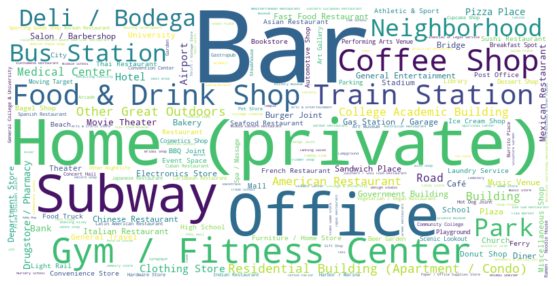

In [20]:
# NYC Venue Categories
nyc_word_cloud = wordcloud.generate_from_frequencies(df[nyc].groupby('venueCategory').size().to_dict())
plt.figure(figsize=(10,5))
plt.imshow(nyc_word_cloud, interpolation='bilinear')
plt.axis('off')
plt.savefig('img/NYC_Venue_Categories.png')
plt.show()

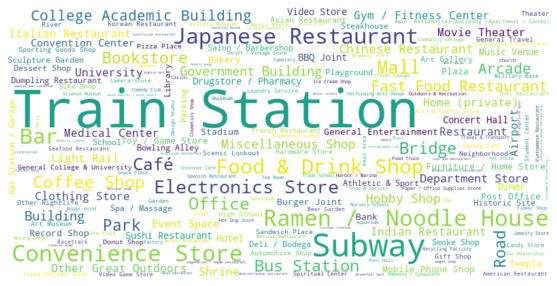

In [21]:
# TKY Venue Categories
tyo_word_cloud = wordcloud.generate_from_frequencies(df[tyo].groupby('venueCategory').size().to_dict())
plt.figure(figsize=(10,5))
plt.imshow(tyo_word_cloud, interpolation='bilinear')
plt.axis('off')
plt.savefig('img/TYO_Venue_Categories.png')
plt.show()

#### _Venue Types_ Distribution

In [22]:
# Venue Types
nyc_venue_types = df[nyc].groupby('venueType')
tyo_venue_types = df[tyo].groupby('venueType')

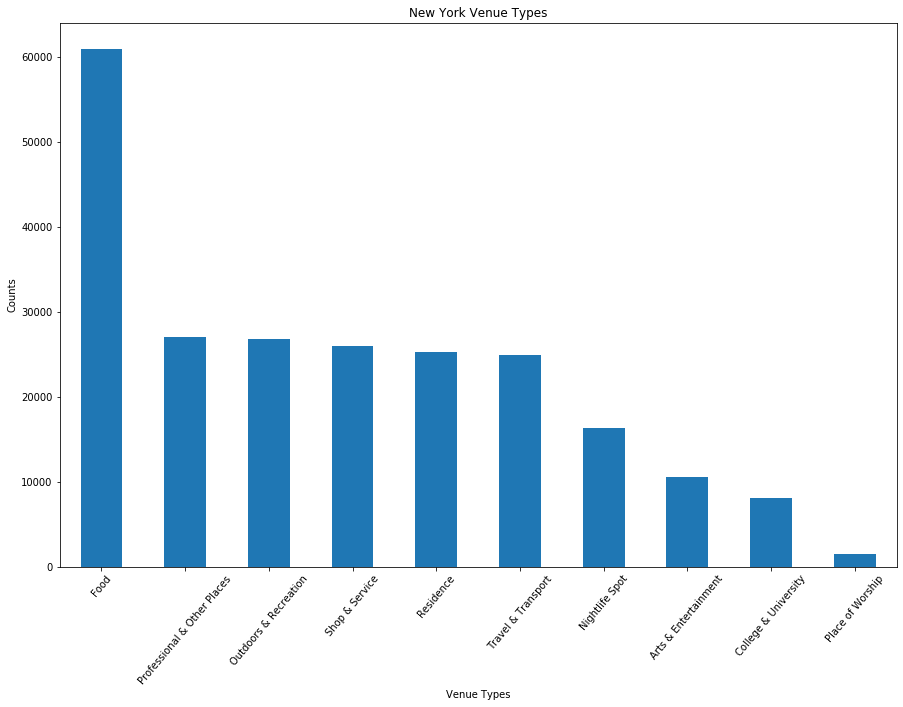

In [23]:
# NYC Venue Types
plt.figure(figsize=(15,10))
nyc_venue_types.size().sort_values(ascending=False).plot.bar()
plt.xticks(rotation=50)
plt.xlabel('Venue Types')
plt.ylabel('Counts')
plt.title('New York Venue Types')
plt.savefig('img/NYC_Venue_Types.png')
plt.show()

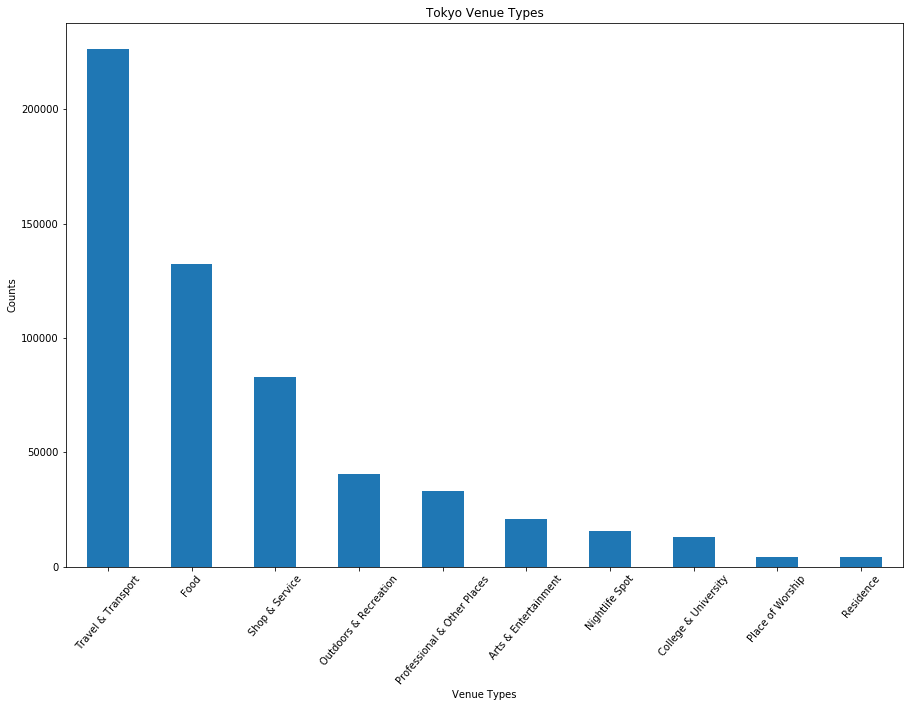

In [24]:
# TKY Venue Types
plt.figure(figsize=(15,10))
tyo_venue_types.size().sort_values(ascending=False).plot.bar()
plt.xticks(rotation=50)
plt.xlabel('Venue Types')
plt.ylabel('Counts')
plt.title('Tokyo Venue Types')
plt.savefig('img/TYO_Venue_Types.png')
plt.show()

#### _Time of the Day_ Distribution